# Customer Segmentation using RFM-Based Behavioral Features

**Part 2 of 4 — Retail Customer Intelligence**  
Segment customers based on purchasing behavior to support targeted marketing, retention, and revenue optimization strategies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


#### Loading the data

**Note:** We use train-only customer features to avoid leakage.

In [2]:
DATA_PATH = Path("..") / "data" / "processed" / "customer_features_train.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["last_purchase"])

df.head(), df.shape

(   customer_id  recency_days  frequency_invoices  monetary  avg_order_value  \
 0      12346.0           235                  12  77556.46      2281.072353   
 1      12347.0            39                   6   4114.18        21.098359   
 2      12348.0           158                   4   1709.40        35.612500   
 3      12349.0           317                   3   2671.14        26.187647   
 4      12350.0           219                   1    334.40        19.670588   
 
    avg_items_per_invoice  active_months       last_purchase  
 0            2184.852941              5 2011-01-18 10:01:00  
 1              12.400000              6 2011-08-02 08:48:00  
 2              52.020833              4 2011-04-05 10:47:00  
 3               9.735294              3 2010-10-28 08:23:00  
 4              11.588235              1 2011-02-02 16:01:00  ,
 (5281, 8))

#### Feature Selection for Segmentation

We use behavioral features that reflect customer value and engagement.

In [3]:
features = df[[
    "recency_days",
    "frequency_invoices",
    "monetary",
    "avg_order_value",
    "avg_items_per_invoice",
    "active_months"
]].copy()

features.describe()


,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months
count,5281.000000,5281.000000,5281.000000,5281.000000,5281.000000,5281.000000
mean,207.282901,5.745692,2705.436178,39.063667,21.043025,3.992804
std,175.007174,11.464582,12535.825033,277.652379,99.898776,4.020490
min,0.000000,1.000000,2.900000,1.450000,1.000000,1.000000
25%,49.000000,1.000000,323.860000,11.468571,5.425770,1.000000
50%,164.000000,3.000000,804.020000,17.354429,9.423077,2.000000
75%,326.000000,6.000000,2118.750000,24.355385,14.104478,5.000000
max,648.000000,309.000000,484615.100000,13305.500000,3501.587302,22.000000


### Feature Transformation

Skewed monetary and frequency variables are log-transformed before scaling.

In [4]:
# Log-transform heavy-tailed monetary-like features
X = features.copy()

log_cols = [
    "monetary",
    "avg_order_value",
    "avg_items_per_invoice",
    "frequency_invoices"
]

for col in log_cols:
    X[col] = np.log1p(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### KMeans (determing the optimal number of clusters)

We use both Elbow Method and Silhouette Score to balance compactness and separation.

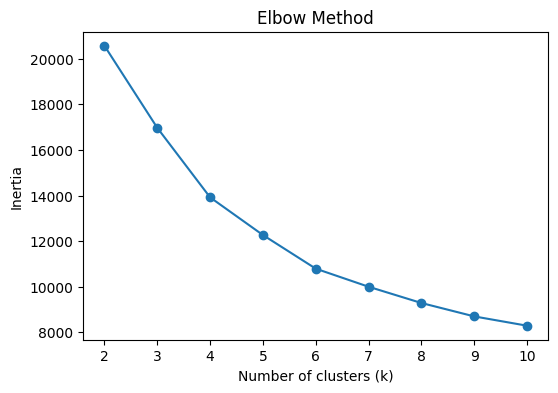

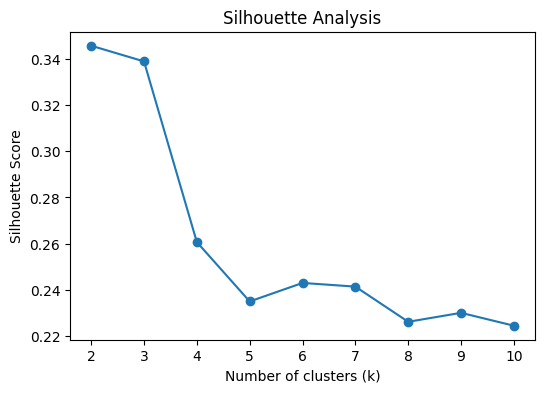

,k,inertia,silhouette
0,2,20572.416512,0.345724
1,3,16972.273371,0.338931
2,4,13921.474940,0.260676
3,5,12268.404885,0.234964
4,6,10792.635500,0.242980
5,7,9999.762918,0.241387
6,8,9286.402036,0.226153
7,9,8698.580725,0.230032
8,10,8290.387322,0.224451


In [5]:
ks = range(2, 11)
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ks, silhouettes, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

pd.DataFrame({
    "k": ks,
    "inertia": inertias,
    "silhouette": silhouettes
})


#### Cluster Stability (k=4)

We test k-means stability across multiple random seeds to ensure the segmentation is not brittle.

In [6]:
# Stability check for k=4 across random seeds
seeds = [0, 1, 2, 3, 4]

stability = []
for seed in seeds:
    km = KMeans(n_clusters=4, random_state=seed, n_init="auto")
    labels = km.fit_predict(X_scaled)
    stability.append({
        "seed": seed,
        "silhouette": silhouette_score(X_scaled, labels),
        "inertia": km.inertia_,
    })

pd.DataFrame(stability).agg({"silhouette": ["mean", "std"], "inertia": ["mean", "std"]})


,silhouette,inertia
mean,0.258952,13919.871949
std,0.001409,1.393660


### Final Customer Segmentation

k=2 has highest silhouette but too broad dividing customers into active and inactive

**k=4** balances separation and adds business usefulness


In [7]:

# Based on the Elbow and Silhouette analysis, we choose k=4 for clustering
final_k = 4
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init="auto")

df["cluster"] = kmeans.fit_predict(X_scaled)
df["cluster"].value_counts().sort_index()

cluster
0    2053
1    2051
2     413
3     764
Name: count, dtype: int64

In [8]:
# Save segmentation artifacts for reuse/deployment
import joblib
from pathlib import Path

MODELS_DIR = Path("..") / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(scaler, MODELS_DIR / "segmentation_scaler.pkl")
joblib.dump(kmeans, MODELS_DIR / "segmentation_kmeans.pkl")


['..\\models\\segmentation_kmeans.pkl']

### Cluster Profiles (Actual Customer Behavior)

In [9]:
cluster_profile = (
    df
    .groupby("cluster")[features.columns]
    .mean()
    .round(2)
)

cluster_counts = df["cluster"].value_counts().sort_index()
cluster_profile["num_customers"] = cluster_counts.values

cluster_profile


,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months,num_customers
cluster,,,,,,,
0,117.24,4.52,1518.93,18.49,10.09,3.84,2053
1,350.51,1.50,375.40,17.19,8.50,1.38,2051
2,242.24,3.84,3210.79,262.90,143.61,2.97,413
3,45.85,21.47,11875.70,32.05,17.88,11.98,764


### Relative Behavior vs Overall Average

Positive values = above average  
Negative values = below average


In [10]:
# Compute overall baseline from full dataset
overall_mean = features.mean()
overall_std = features.std()

# Relative behavior: cluster vs overall population
cluster_relative = (
    cluster_profile[features.columns]
    .subtract(overall_mean, axis=1)
    .divide(overall_std, axis=1)
    .round(2)
)

cluster_relative


,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months
cluster,,,,,,
0,-0.51,-0.11,-0.09,-0.07,-0.11,-0.04
1,0.82,-0.37,-0.19,-0.08,-0.13,-0.65
2,0.20,-0.17,0.04,0.81,1.23,-0.25
3,-0.92,1.37,0.73,-0.03,-0.03,1.99


#### Clustering Labels

Based on absolute metrics (spend, frequency, recency) and relative behavior
compared to the overall customer base, each cluster was assigned a
business-meaningful label to support stakeholder communication.


In [11]:
cluster_labels = {
    0: "Regular Customers",
    1: "High-Value Loyal Customers",
    2: "Wholesale Buyers",
    3: "Inactive / At-Risk Customers"
}

df["cluster_name"] = df["cluster"].map(cluster_labels)

df[["customer_id", "cluster", "cluster_name"]].head()

,customer_id,cluster,cluster_name
0,12346.0,2,Wholesale Buyers
1,12347.0,0,Regular Customers
2,12348.0,2,Wholesale Buyers
3,12349.0,0,Regular Customers
4,12350.0,1,High-Value Loyal Customers


In [12]:
cluster_profile.index = cluster_profile.index.map(cluster_labels)
cluster_relative.index = cluster_relative.index.map(cluster_labels)

In [13]:
print("Customer count per segment:\n")
print(
    df["cluster_name"]
    .value_counts()
    .rename("num_customers")
    .to_frame()
)


Customer count per segment:

                              num_customers
cluster_name                               
Regular Customers                      2053
High-Value Loyal Customers             2051
Inactive / At-Risk Customers            764
Wholesale Buyers                        413


#### Sample customers per cluster

In [14]:
print("\nSample customers from each segment:\n")

for name in df["cluster_name"].unique():
    print(f"\n--- {name} ---")
    display(
        df[df["cluster_name"] == name]
        .head(3)[
            [
                "customer_id",
                "recency_days",
                "frequency_invoices",
                "monetary",
                "avg_order_value",
                "avg_items_per_invoice",
                "active_months"
            ]
        ]
    )



Sample customers from each segment:


--- Wholesale Buyers ---


,customer_id,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months
0,12346.0,235,12,77556.46,2281.072353,2184.852941,5
2,12348.0,158,4,1709.40,35.612500,52.020833,4
11,12357.0,297,2,12079.99,73.212061,23.509091,1



--- Regular Customers ---


,customer_id,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months
1,12347.0,39,6,4114.18,21.098359,12.400000,6
3,12349.0,317,3,2671.14,26.187647,9.735294,3
6,12352.0,171,7,1905.61,34.028750,7.892857,3



--- High-Value Loyal Customers ---


,customer_id,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months
4,12350.0,219,1,334.40,19.670588,11.588235,1
5,12351.0,284,1,300.93,14.330000,12.428571,1
21,12368.0,537,1,917.70,50.983333,18.333333,1



--- Inactive / At-Risk Customers ---


,customer_id,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months
13,12359.0,99,9,6059.09,23.304192,8.057692,7
46,12395.0,21,11,3948.21,20.351598,16.721649,9
65,12415.0,8,22,121631.72,149.792759,99.475369,13


#### Metrics calculated for insights

In [15]:
# Total revenue
total_revenue = df["monetary"].sum()

cluster_summary = (
    df.groupby(["cluster", "cluster_name"])
    .agg(
        customers=("customer_id", "count"),
        revenue=("monetary", "sum")
    )
    .reset_index()
)

cluster_summary["customer_pct"] = (
    cluster_summary["customers"] / cluster_summary["customers"].sum() * 100
).round(1)

cluster_summary["revenue_pct"] = (
    cluster_summary["revenue"] / total_revenue * 100
).round(1)

cluster_summary.sort_values("revenue_pct", ascending=False)


,cluster,cluster_name,customers,revenue,customer_pct,revenue_pct
3,3,Inactive / At-Risk Customers,764,9073034.879,14.5,63.5
0,0,Regular Customers,2053,3118363.834,38.9,21.8
2,2,Wholesale Buyers,413,1326055.731,7.8,9.3
1,1,High-Value Loyal Customers,2051,769954.012,38.8,5.4


#### PCA for Plots

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)

pca_df["cluster"] = df["cluster"]
pca_df["cluster_name"] = df["cluster_name"]

pca_df.head()


,PC1,PC2,cluster,cluster_name
0,4.787513,7.646440,2,Wholesale Buyers
1,1.571463,-0.106854,0,Regular Customers
2,0.961029,1.667805,2,Wholesale Buyers
3,0.068669,0.432518,0,Regular Customers
4,-1.230957,0.527663,1,High-Value Loyal Customers


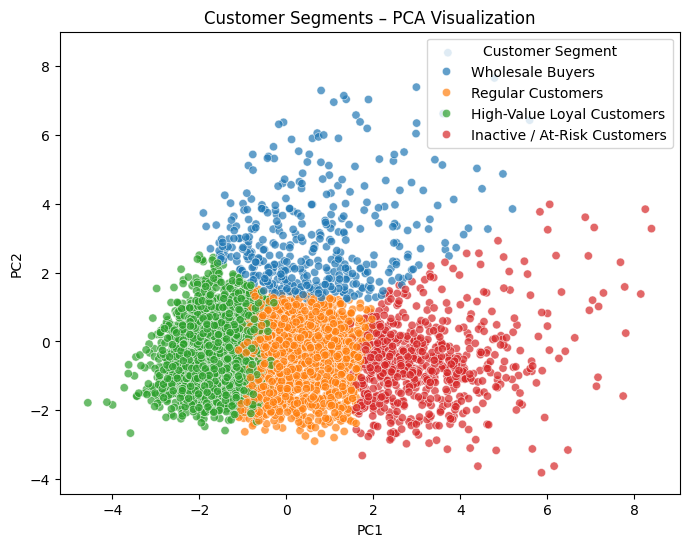

In [17]:
# PCA Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="cluster_name",
    palette="tab10",
    alpha=0.7
)
plt.title("Customer Segments – PCA Visualization")
plt.legend(title="Customer Segment")
plt.show()


In [18]:
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


Explained variance ratio:
[0.53440995 0.28263071]
Total variance explained: 81.70%


#### Save Customer-level segmentation output

In [19]:
# =========================
# Save Customer Segments
# =========================

segments = df[[
    "customer_id",
    "cluster",
    "cluster_name",
    "recency_days",
    "frequency_invoices",
    "monetary",
    "avg_order_value",
    "avg_items_per_invoice",
    "active_months",
    "last_purchase"
]].copy()

segments.to_csv(
    "../data/processed/customer_segments.csv",
    index=False
)

print(f"Saved {segments.shape[0]} customer records with segmentation")
segments.head()


Saved 5281 customer records with segmentation


,customer_id,cluster,cluster_name,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months,last_purchase
0,12346.0,2,Wholesale Buyers,235,12,77556.46,2281.072353,2184.852941,5,2011-01-18 10:01:00
1,12347.0,0,Regular Customers,39,6,4114.18,21.098359,12.400000,6,2011-08-02 08:48:00
2,12348.0,2,Wholesale Buyers,158,4,1709.40,35.612500,52.020833,4,2011-04-05 10:47:00
3,12349.0,0,Regular Customers,317,3,2671.14,26.187647,9.735294,3,2010-10-28 08:23:00
4,12350.0,1,High-Value Loyal Customers,219,1,334.40,19.670588,11.588235,1,2011-02-02 16:01:00


#### Cluster-level summary

In [20]:
# =========================
# Save Cluster Summary
# =========================

cluster_summary = (
    segments
    .groupby(["cluster", "cluster_name"])
    .agg(
        customers=("customer_id", "count"),
        total_revenue=("monetary", "sum"),
        avg_revenue=("monetary", "mean"),
        avg_frequency=("frequency_invoices", "mean"),
        avg_recency=("recency_days", "mean")
    )
    .reset_index()
)

cluster_summary.to_csv(
    "../data/processed/cluster_summary.csv",
    index=False
)

cluster_summary


,cluster,cluster_name,customers,total_revenue,avg_revenue,avg_frequency,avg_recency
0,0,Regular Customers,2053,3118363.834,1518.930265,4.516805,117.241598
1,1,High-Value Loyal Customers,2051,769954.012,375.404199,1.502194,350.505119
2,2,Wholesale Buyers,413,1326055.731,3210.788695,3.840194,242.239709
3,3,Inactive / At-Risk Customers,764,9073034.879,11875.700103,21.469895,45.854712


In [21]:
# =========================
# Save Features for Modeling
# =========================

model_features = segments.drop(columns=["cluster_name"])

model_features.to_csv(
    "../data/processed/model_features.csv",
    index=False
)


In [22]:
model_features.head()

,customer_id,cluster,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months,last_purchase
0,12346.0,2,235,12,77556.46,2281.072353,2184.852941,5,2011-01-18 10:01:00
1,12347.0,0,39,6,4114.18,21.098359,12.400000,6,2011-08-02 08:48:00
2,12348.0,2,158,4,1709.40,35.612500,52.020833,4,2011-04-05 10:47:00
3,12349.0,0,317,3,2671.14,26.187647,9.735294,3,2010-10-28 08:23:00
4,12350.0,1,219,1,334.40,19.670588,11.588235,1,2011-02-02 16:01:00


## Customer Segmentation Overview

| Segment | Description | Customers | % of Customers | % of Revenue | Key Business Insight |
|------|------------|----------|---------------|-------------|--------------------|
| High-Value Loyal Customers | Frequent, long-term, high spenders | 1,079 | 18.4% | 68.4% | Small segment drives majority of revenue |
| Regular Customers | Moderate spend and frequency | 2,607 | 44.4% | 17.6% | Largest group with strong upsell potential |
| Wholesale Buyers | Infrequent but very high order values | 445 | 7.6% | 9.7% | High revenue efficiency, low consistency |
| Inactive / At-Risk Customers | Long time since last purchase | 1,747 | 29.7% | 4.2% | High churn risk, low revenue impact |

### Key Business Insights & Recommended Actions

- **18% of customers generate ~68% of total revenue**  
  → Prioritize loyalty programs, exclusive offers, and premium support to protect core revenue.

- **44% of customers contribute only ~18% of revenue**  
  → Strong upsell and cross-sell opportunity through targeted promotions and bundles.

- **8% wholesale buyers generate ~10% of revenue**  
  → Introduce contract pricing or volume-based incentives to stabilize repeat purchases.

- **30% of customers are inactive or at high churn risk**  
  → Use low-cost win-back campaigns or deprioritize to reduce wasted marketing spend.

- **Revenue is highly concentrated in a small segment**  
  → Customer retention has a significantly higher ROI than customer acquisition.
